In [1]:
import torch
import matplotlib.pyplot as plt
import tikzplotlib

In [9]:
# Fix for matplotlib legend
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

### Function for coupled traffic lights

Starting state assumed to be A - generalize this to being either A or B

dt is waiting time from light turning yellow to next light turning green
A positive jump at 0, negative jump at t1, positive jump at t1 + dt + t2 + dt, negative jump at t1 + dt + t2 + dt + t1

A two jumps - B two jumps - A two jumps - B two jumps etc


In [2]:
def jump(x, start):
    return torch.sigmoid(x - (start + 5)) # Plus 5 to shift start of sigmoid to start

def full_jump(x, start, t):
    return jump(x, start) - jump(x, start + t)


def construct_activation(T, t1, t2, dt = 15, starting_state = 1):
    '''
    Constructs activation functions given the time interval, T, the cycle times t1 and t2
    The time between jumps dt and the starting state
    '''

    #########################################################
    # STEP 1: Calculate the number of full periods to be used
    #########################################################

    period_time = t1 + dt + t2 + dt
    # Rounding the number of periods up to not add activation function
    # over a too short period
    n_periods = int(torch.ceil( T / period_time))

    #########################################################
    # STEP 2: Initialize the activation functions
    #########################################################

    if starting_state:
        # A state is first state
        def a_activation(x):
            # Add first period no matter what
            out = full_jump(x, 0, t1)

            for i in range(1, n_periods):
                # Start from 1 since first period already added
                # If a new period is started on, add the whole period
                out += full_jump(x, i*period_time, t1)
            return out

        def b_activation(x):
            # Add first jump no matter what
            out = full_jump(x, t1+dt, t2)

            for i in range(1, n_periods):
                # Start from 1 since first period already added
                # If a new period is started on, add the whole period
                out += full_jump(x, i*period_time + t1+dt, t1)
            return out

        
    else:
        # B state is first state
        # Swap functions above
        def a_activation(x):
            # Add first period no matter what
            out = full_jump(x, t2+dt, t1)

            for i in range(1, n_periods):
                # Start from 1 since first period already added
                # If a new period is started on, add the whole period
                out += full_jump(x, i*period_time+t2+dt, t1)
            return out

        def b_activation(x):
            # Add first jump no matter what
            out = full_jump(x, 0, t2)

            for i in range(1, n_periods):
                # Start from 1 since first period already added
                # If a new period is started on, add the whole period
                out += full_jump(x, i*period_time, t2)
            return out
        
    return a_activation, b_activation

In [3]:
T = 200
x = torch.linspace(0,T, 1000)
t1 = 20
t2 = 30
dt = 15

a_act, b_act = construct_activation(torch.tensor([T]), t1, t2, dt, starting_state=False)

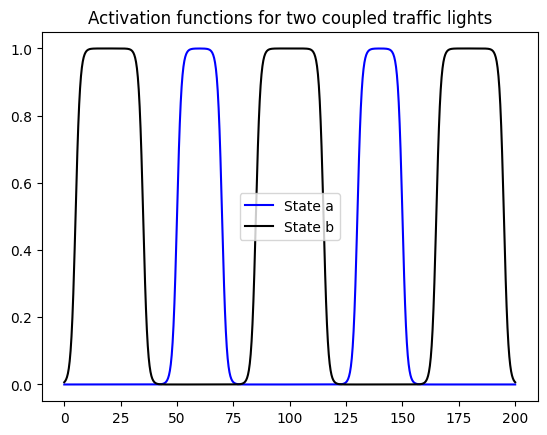

In [10]:
a, b = a_act(x), b_act(x)

# Plotting figure
fig = plt.figure()
plt.plot(x, a, 'b', label='State a')
plt.plot(x, b, 'k', label ='State b')
plt.title("Activation functions for two coupled traffic lights")
plt.legend()

# Fixing issue with legend
tikzplotlib_fix_ncols(fig)

# Saving as tikz figure
tikzplotlib.save("../figurer/activation_function.tex")

In [ ]:

x = torch.linspace(0,160, 1000)

active = jump(x, 0) - jump(x, t1) # active 
active += jump(x, t1 + 15 + t2 + 15) - jump(x, t1 + 15 + t2 + 15 + t1)

active_b = jump(x,t1+15) - jump(x, t1+15+t2)
active_b += jump(x,t1+15+t2+15+t1+15) - jump(x,t1+15+t2+15+t1+15+t2)

plt.plot(x, active)
plt.plot(x, active_b, 'k')

plot_lines = False
if plot_lines:
    plt.plot([0,0], [0,1], '--r')
    plt.plot([t1,t1], [0,1], '--r')
    plt.plot([t1+15, t1+15], [0,1], '--k')
    plt.plot([t1+15+t2, t1+15+t2], [0,1], '--k')
    plt.plot([t1+15+t2+15, t1+15+t2+15], [0,1], '--r')
    plt.plot([t1+15+t2+15+t1, t1+15+t2+15+t1], [0,1], '--r')
    plt.plot([t1+15+t2+15, t1+15+t2+15], [0,1], '--r')
    plt.plot([t1+15+t2+15+t1, t1+15+t2+15+t1], [0,1], '--r')
    plt.plot([t1+15+t2+15+t1+15, t1+15+t2+15+t1+15], [0,1], '--k')
    plt.plot([t1+15+t2+15+t1+15+t2, t1+15+t2+15+t1+15+t2], [0,1], '--k')


plt.show()

### Optimizing wrt traffic lights

Explicitely adding traffic lights to scheme by modelling flux through traffic lights as desired influx multiplied by a function f that depens on the cycle of the trafffic light. 
The function f should be sigmoid like, periodic and have the S-shape going both directions.

In [2]:
# a = torch.tensor(22.) # Time spent as green
# b = torch.tensor(24.) # Time spent as red
# T = 600
# x = torch.linspace(0,T, 1000)

In [3]:
# m = torch.nn.Sigmoid()

# a1 = torch.tensor(22., requires_grad=True)
# a2 = torch.tensor(80., requires_grad=True)

# out = m(a1+a2-5)

# first = torch.autograd.grad(out, a1, create_graph=True, allow_unused=True)[0]
# second = torch.autograd.grad(out, a2, create_graph=True, allow_unused=True)[0]


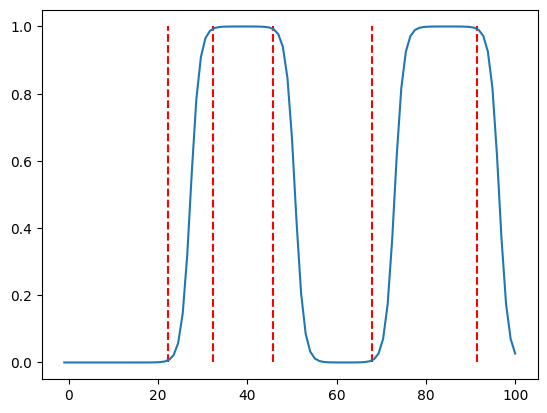

In [3]:
sigmoid = torch.sigmoid

def one_period(x, const1, const2):
    return sigmoid(x - (const1 + 5)) - sigmoid(x - (const1 + const2 + 5))

def full_function(x, c1, c2, T):
    '''
    Repeating a single period for a total time of T
    '''
    period_time = c1.detach() + c2.detach() # Time of a single period

    n_periods = int(torch.ceil(T / period_time)) # Number of periods the time interval spans

    out = one_period(x, c1, c2)

    for i in range(1, n_periods):
        out += one_period(x, i*period_time + c1, c2)

    return out

def full_function_2(x, c1, c2, T):
    '''
    Repeating a single period for a total time of T
    '''
    period_time = c1.detach() + c2.detach() # Time of a single period

    n_periods = int(torch.ceil(T / period_time)) # Number of periods the time interval spans

    out = one_period(x, c1, c2)

    for i in range(1, n_periods):
        out += one_period(x, i*period_time + c1, c2)

    return out



x = torch.linspace(-1,100, 100)
y = full_function(x, torch.tensor(22.3), torch.tensor(23.4), 100)

plt.plot([22.3, 22.3], [0,1], 'r--')
plt.plot([32.3, 32.3], [0,1], 'r--')
plt.plot([45.7, 45.7], [0,1], 'r--')
plt.plot([68.0, 68.0], [0,1], 'r--')
plt.plot([91.4, 91.4], [0,1], 'r--')

plt.plot(x, y)
plt.show()


In [20]:
t1 = 49.7219
t2 = 45.0
jump_time = 10
t = 1024.134335

period_time = t % (t1+t2)
print(period_time)
if period_time < 10:
    print(t - period_time + 10)
elif period_time < t1:
    print(t- period_time + t1)
else:
    print(t- period_time + t1 + t2)



76.91533499999991
1041.9409


In [5]:
# def sigmoid(x, const):
#     return 1. / (1. + torch.exp(- x + const + 5))

# def full_period_sigmoid(x, const1, const2):
#     return sigmoid(x,const1) - sigmoid(x, const1 + const2)

# def full_function(x, c1, c2, T):
#     '''
#     T is full time of simulation
#     '''
#     cycle_time = c1.detach() + c2.detach()
#     n_full_cycles = int(T // cycle_time)
#     out = full_period_sigmoid(x, c1, c2)
#     for i in range(1, n_full_cycles):
#         # Add as many full cycles as possible
#         out = out + full_period_sigmoid(x, i*cycle_time + c1, c2)

#     return out

In [6]:
# x_test = 6.1224

# const = torch.tensor([89.8, 89.9])#linspace(10, 90, 100)
# y = []
# for c in const:
#     test = c.clone().detach().requires_grad_(True)
#     out = torch.exp(-x_test+test) #sigmoid(x_test, test)
#     derivative = torch.autograd.grad(out, test, create_graph=True, allow_unused=True)[0]
#     print(derivative)
#     y.append(derivative.detach())

# plt.plot(const, y)
# plt.show()

In [7]:
# # Testing derivative of exponential functin
# a = torch.tensor(15.7, requires_grad=True)
# b = torch.tensor(20.1, requires_grad=True)
# x_list = torch.linspace(0, 50, 100)
# objective = full_function(x_list[0], a, b, 50)
# for x in x_list[1:]:
#     objective += full_function(x, a, b, 50)

# print(objective)
# derivative = torch.autograd.grad(objective, a, create_graph=True, allow_unused=True)[0]
# derivative2 = torch.autograd.grad(objective, b, create_graph=True, allow_unused=True)[0]
# print(derivative, derivative2)

In [8]:
# y = full_function(x_list, a, b, 50)
# plt.plot(x_list, y.detach())
# plt.show()

In [9]:
# x = torch.linspace(0,T, 1000)

# y = full_function(x, a, b, T)

In [10]:
# #y = full_period_sigmoid(x, a, b)
# plt.plot(x, y.detach())
# plt.plot([22, 22], [0,1], 'r', linestyle='--')
# plt.plot([46, 46], [0,1], 'r', linestyle='--')
# plt.show()

Testing optimization of this function with goal of matching similar function

In [75]:
a_hidden, b_hidden = torch.tensor(50.), torch.tensor(10.)
T = 600
x = torch.linspace(0,T, 100)

dummy_rho = 2*full_function(x, a_hidden, b_hidden, T) - 1

x_ = torch.linspace(10.,100.,100)
y_ = torch.linspace(10.,100.,100)

XX, YY = torch.meshgrid(x_, y_, indexing='ij')

test = torch.zeros((len(x_), len(y_)))
for i in range(len(x_)):
    for j in range(len(y_)):
        filter = full_function(x, x_[i], y_[j], T)
        test[i,j] = torch.dot(dummy_rho, filter)

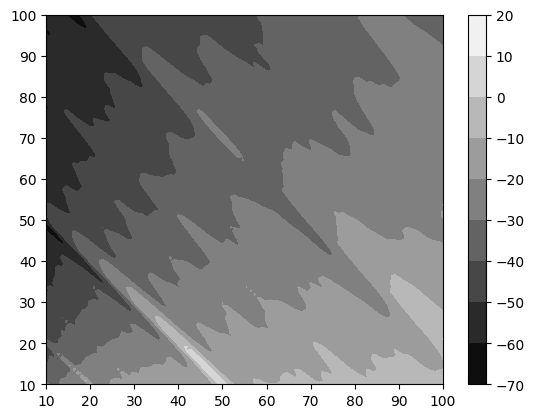

In [76]:
plt.contourf(XX.numpy(), YY.numpy(), test.numpy(), cmap="gray")
plt.colorbar()
plt.show()

tensor(-75.9068, grad_fn=<NegBackward0>)
tensor(-8.7629, grad_fn=<AddBackward0>)
tensor(33.2848, grad_fn=<AddBackward0>)


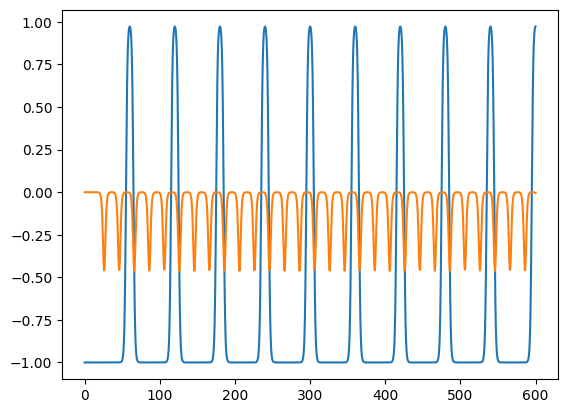

In [36]:
a_hidden, b_hidden = torch.tensor(50.), torch.tensor(10.)
T = 600
x = torch.linspace(0,T, 1000)

dummy_rho = 2*full_function(x, a_hidden, b_hidden, T) - 1

# plt.plot(x, dummy_rho)
# plt.show()
a, b = torch.tensor(22., requires_grad=True), torch.tensor(-2., requires_grad=True)
test_solution = full_function(x, a, b, T)

objective = -torch.dot(dummy_rho, test_solution)
first = torch.autograd.grad(objective, a, create_graph=True, allow_unused=True)[0]
second = torch.autograd.grad(objective, b, create_graph=True, allow_unused=True)[0]

print(objective)
print(first)
print(second)

plt.plot(x, dummy_rho)
plt.plot(x, test_solution.detach())
plt.show()

In [70]:
a_guess, b_guess = torch.tensor(25.0, requires_grad=True), torch.tensor(25.0, requires_grad=True)

for i in range(100):
    # Naive test without using line-search for steplength
    if i == 0:
        filter = full_function(x, a_guess, b_guess, T)
        objective = -torch.dot(dummy_rho, filter)
        first = torch.autograd.grad(objective, a_guess, create_graph=True, allow_unused=True)[0]
        second = torch.autograd.grad(objective, b_guess, create_graph=True, allow_unused=True)[0]
    
    print(f"Objective: {objective}")
    # Naive steplength control
    alpha = 2
    step_taken = False
    while not step_taken:
        if alpha*first <= a_guess:
            new_a = a_guess.clone().detach().requires_grad_(True) - alpha*first.detach()
        else:
            new_a = torch.tensor(0., requires_grad=True)

        if alpha*second <= b_guess:
            new_b = b_guess.clone().detach().requires_grad_(True) - alpha*second.detach()
        else:
            new_b = torch.tensor(0., requires_grad=True)


        new_filter = full_function(x, new_a, new_b, T)
        new_objective = -torch.dot(dummy_rho, new_filter)
        new_first = torch.autograd.grad(new_objective,new_a, create_graph=True, allow_unused=True)[0]
        new_second = torch.autograd.grad(new_objective, new_b, create_graph=True, allow_unused=True)[0]

        if new_objective <= objective - alpha*10**(-4)*(first*first + second*second):
            step_taken = True
            a_guess, b_guess = new_a, new_b
            first, second = new_first, new_second
            objective = new_objective
        else:
            print("Armijo Failed")
            print(first, second)
            alpha *= 0.5

    print(f"Guess after {i+1}. iteration:")
    print(f"a: {a_guess}, b: {b_guess}")
    print(f"Objective value: {objective}\n")




Objective: -33.12580108642578
Guess after 1. iteration:
a: 25.143978118896484, b: 27.74125862121582
Objective value: -38.298336029052734

Objective: -38.298336029052734
Guess after 2. iteration:
a: 25.526710510253906, b: 30.63694953918457
Objective value: -39.18985366821289

Objective: -39.18985366821289
Guess after 3. iteration:
a: 26.806249618530273, b: 33.8676872253418
Objective value: -43.80815505981445

Objective: -43.80815505981445
Armijo Failed
tensor(3.1205, grad_fn=<AddBackward0>) tensor(1.7595, grad_fn=<AddBackward0>)
Armijo Failed
tensor(3.1205, grad_fn=<AddBackward0>) tensor(1.7595, grad_fn=<AddBackward0>)
Guess after 4. iteration:
a: 25.246017456054688, b: 32.98795700073242
Objective value: -53.832115173339844

Objective: -53.832115173339844
Armijo Failed
tensor(-0.1794, grad_fn=<AddBackward0>) tensor(-1.5851, grad_fn=<AddBackward0>)
Guess after 5. iteration:
a: 25.425378799438477, b: 34.57306671142578
Objective value: -53.88413619995117

Objective: -53.88413619995117
Armi

In [101]:
a = torch.tensor(10.049, requires_grad=True)
b = torch.tensor(25.91, requires_grad=True)

filter = full_function(x, a, b, T)

tensor(54.9515, grad_fn=<DotBackward0>)


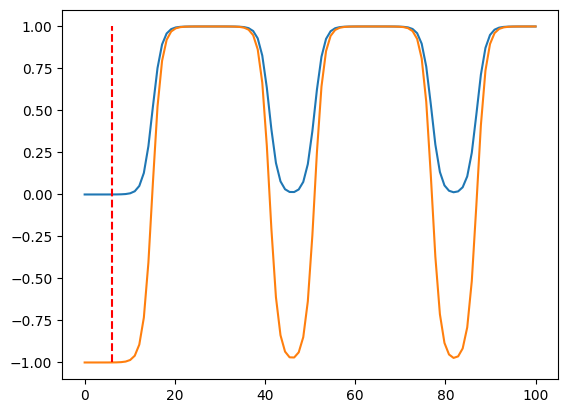

In [102]:
print(torch.dot(dummy_rho, filter))
plt.plot(x, filter.detach())
plt.plot(x, dummy_rho)
plt.plot([6.1224, 6.1224], [-1,1], 'r--')
plt.show()

In [59]:
# Finding where it crashes:
objective = torch.dot(dummy_rho, filter)

first = torch.autograd.grad(objective, a, create_graph=True, allow_unused=True)[0]
second = torch.autograd.grad(objective, b, create_graph=True, allow_unused=True)[0]

print(first)
print(second)

tensor(-2.5118, grad_fn=<AddBackward0>)
tensor(-1.1863, grad_fn=<AddBackward0>)


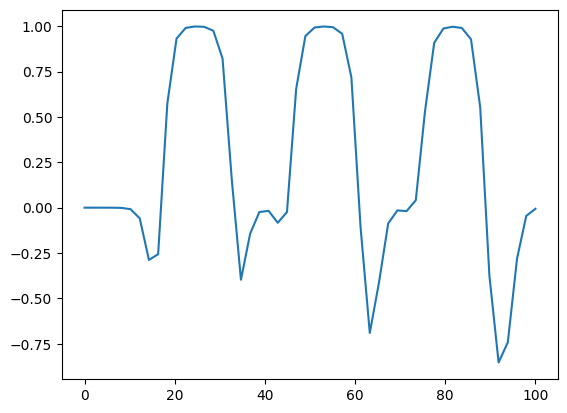

In [42]:
mask = dummy_rho*filter
plt.plot(x, mask.detach())
plt.show()

In [ ]:
# Backup for coupled traffic lights

{
    "T" : 120,
    "roads" : [
        {
            "L" : 1000,
            "b" : 1,
            "Vmax" : [50],
            "Vlow" : 50,
            "Vhigh" : 50,
            "N" : 50,
            "Scheme" : 3,
            "Init_dens" : 1.0,
            "Init_distr" : 1,
            "Inflow" : 0.4,
            "ControlPoints" : []
        }, 
        {
            "L" : 1000,
            "b" : 2,
            "Vmax" : [50],
            "Vlow" : 50,
            "Vhigh" : 50,
            "N" : 50,
            "Scheme" : 3,
            "Init_dens" : 0.1,
            "Init_distr" : 1,
            "Inflow" : 0.1,
            "ControlPoints" : []
        },
        {
            "L" : 1000,
            "b" : 1,
            "Vmax" : [50],
            "Vlow" : 50,
            "Vhigh" : 50,
            "N" : 50,
            "Scheme" : 3,
            "Init_dens" : 1.0,
            "Init_distr" : 1,
            "Inflow" : 0.4,
            "ControlPoints" : []
        }, 
        {
            "L" : 1000,
            "b" : 2,
            "Vmax" : [50],
            "Vlow" : 50,
            "Vhigh" : 50,
            "N" : 50,
            "Scheme" : 3,
            "Init_dens" : 0.1,
            "Init_distr" : 1,
            "Inflow" : 0.1,
            "ControlPoints" : []
        }
    ],
    "Junctions" : [
        {
            "Roads" : [0,1,2,3],
            "Entering" : [0,2],
            "Leaving" : [1,3],
            "Distribution" : [
                                [1.0, 0.0],
                                [0.0, 1.0]
                            ],
            "Trafficlights" : [
                {
                    "StartingState" : "Red",
                    "Entering" : [0],
                    "Leaving" : [3],
                    "Cycle" : [120.0, 15.0]
                },
                {
                    "StartingState" : "Red",
                    "Entering" : [2],
                    "Leaving" : [1],
                    "Cycle" : [120.0, 15.0]
                }
            ],
            "CoupledTrafficlights" : [
                {
                    "StartingState" : "Green",
                    "aEntering" : [0],
                    "aLeaving" : [1],
                    "bEntering" : [2],
                    "bLeaving" : [3],
                    "Cycle" : [35.0, 14.5774]
                }
            ]
        }
    ]
}